In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/metall/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit


from keras.models import load_model
#!pip install joblib
import joblib


path = '/content/drive/MyDrive/Прогноз металлические заготовки/cloud/'
file_name = 'data_for_lstm.csv'

df = pd.read_csv(path + file_name)
df.drop(['timepoint'], axis=1, inplace=True)


## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

def lstm_trained(features_set,labels,epochs = 40, batch_size = 4,num_layers=1,p=0.0,units=12,optimizer='adam'):
  '''
  
  return trained lstm
  save model as lstm.hdf5
  
  '''
  model = Sequential()
  if num_layers==2:
    model.add(LSTM(name='start_layer',units=units, return_sequences=True, input_shape=(features_set.shape[1],features_set.shape[2] )))
    model.add(Dropout(p))
    
  elif num_layers>2:
    model.add(LSTM(name='layer_{}'.format(i),units=units, return_sequences=True, input_shape=(features_set.shape[1],features_set.shape[2] )))
    for layer in range(num_layers-1):
      model.add(LSTM(name='prelast_layer',units=units, return_sequences=True))
      model.add(Dropout(p))

  model.add(LSTM(name='last_layer',units=units))
  model.add(Dropout(p))
  model.add(Dense(units = 1))
  model.compile(optimizer = optimizer, loss = 'mean_squared_error')
  model.fit(features_set, labels, epochs = epochs, batch_size = batch_size, verbose=1)
  model.save(path+'lstm.hdf5')
  return model



## predictions of lstm

In [ ]:
def lstm_predict(df_train,df_test,shift, epochs = 2, batch_size = 8,num_layers=1,p=0.0,units=48,optimizer='adam'):
  '''

  returns the prediction lstm, trainded model, trainded scaler
  save scaler as scaler_lstm

  params:
  shift - the length of the background
  other - dataframes or params for lstm

  '''
  scaler = MinMaxScaler(feature_range = (0, 1))
  df_training_processed = df_train.iloc[:, :].values
  df_training_scaled = scaler.fit_transform(df_training_processed)
  joblib.dump(scaler, path+'/scaler_lstm') 
  features_set = []
  labels = []
  # We will make predictions for the next week based on the history (length of shift=length_history)
  # Let's form this selection
  len_ = df_training_scaled.shape[0]
  for i in range(shift, len_):
      features_set.append(df_training_scaled[i-shift:i, :])
      labels.append(df_training_scaled[i, 0])

  # Convert to an np array and make a suitable format for LSTM, train the model
  features_set, labels = np.array(features_set), np.array(labels)
  features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], features_set.shape[2]))
  model = lstm_trained(features_set, labels,epochs=epochs,batch_size=batch_size, p=p, num_layers=num_layers, optimizer=optimizer)

  # Let's create a sample for testing
  df_total = pd.concat((df_train, df_test), axis=0)
  test_inputs = df_total[len(df_total) - len(df_test) - shift:]
  test_inputs_processed = test_inputs.iloc[:, :].values
  test_inputs_scaled= scaler.transform(test_inputs_processed)
  test_features = []
  for i in range(shift, len(test_inputs_scaled)):
      test_features.append(test_inputs_scaled[i-shift:i, :])

  # Convert again to an np array and make a format suitable for LSTM  test_features = np.array(test_features)
  test_features = np.array(test_features)
  test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

  predictions = model.predict(test_features)
  predictions=predictions.reshape(df_test.shape[0],)

  test_data_processed = (df_test.copy()).iloc[:].values
  test_data_processed[:,0] = predictions
  test_data_processed = scaler.inverse_transform(test_data_processed)
  predictions = test_data_processed[:,0]

  return predictions,model,scaler

## grid and model selection



In [ ]:
from sklearn.model_selection import ParameterGrid

grid = ParameterGrid({'num_layers': [0,1,2,4], 
                      'epochs':[40,60],
                      'p':[0.0,0.1,0.2],
                      'length_history':[4,8,12],
                      'n_splits':[20],
                      'units':[4,8,24,48],
                      'min_len_datasets':[30],
                      'length_prediction':[1]})

In [ ]:
grid = ParameterGrid({'num_layers': [1], 
                      'epochs':[60],
                      'p':[0.0],
                      'length_history':[8],
                      'n_splits':[10],
                      'units':[4,8,24,48],
                      'min_len_datasets':[30],
                      'length_prediction':[1]})

let's calculate the average mae for different grid architectures using timeseriescv

based on the scores of the grid, we choose the architecture of the solution, train it and save the model, scaler


In [ ]:
from tqdm.notebook import tqdm

scores = dict()

for item in tqdm(grid):  
  values = (df.copy()).values
  length_prediction = item['length_prediction']
  n_splits = item['n_splits']
  min_len_datasets= item['min_len_datasets']
  length_history=item['length_history']
  tscv = TimeSeriesSplit(n_splits=n_splits,test_size=length_prediction)
  res = []
  for id_train,id_test in tscv.split(values):
    df_train=df.iloc[id_train,:].copy()
    if (len(df_train)<length_history+min_len_datasets):
      continue
    df_test=df.iloc[id_test,:].copy()
    predictions,model,scaler = lstm_predict(df_train.copy(), df_test.copy(), shift=length_history,
                               epochs=item['epochs'],p=item['p'],num_layers=item['num_layers'],units=item['units'])
    error = 0
    targets = df_test['target'].values
    for i in range(len(predictions)):
      error+=abs(predictions[i]-targets[i])
    res.append(error/len(predictions))

  scores[str(item)] = [np.mean(res)] 

In [ ]:
scores

{"{'epochs': 60, 'length_history': 8, 'length_prediction': 1, 'min_len_datasets': 30, 'n_splits': 10, 'num_layers': 1, 'p': 0.0}": [40.38502165675163]}

#Trash

## Предикт по последним данным. Надо от таблицы данные за последние length_history




In [ ]:
def predict(scaler,model,df_train,df_test,shift):

  scaler = scaler
  df_training_processed = df_train.iloc[:, :].values
  df_training_scaled = scaler.transform(df_training_processed)
  model = model

  # Создадим выборку для тестирования
  df_total = pd.concat((df_train, df_test), axis=0)
  test_inputs = df_total[len(df_total) - len(df_test) - shift:]
  test_inputs_processed = test_inputs.iloc[:, :].values
  test_inputs_scaled= scaler.transform(test_inputs_processed)
  test_features = []
  for i in range(shift, len(test_inputs_scaled)):
      test_features.append(test_inputs_scaled[i-shift:i, :])

  # Преобразуем опять в массив np и сделаем подходящий для LSTM формат
  test_features = np.array(test_features)
  test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

  predictions = model.predict(test_features)
  predictions=predictions.reshape(df_test.shape[0],)

  test_data_processed = (df_test.copy()).iloc[:].values
  test_data_processed[:,0] = predictions
  test_data_processed = scaler.inverse_transform(test_data_processed)
  predictions = test_data_processed[:,0]
  
  return predictions

In [ ]:
model = load_model(path+'lstm.hdf5')
scaler = joblib.load(path+'/scaler_lstm') 

In [ ]:
len_ = df.shape[0]
df_train = df.iloc[len_-length_history-1:len_-1,:].copy()
df_test = df.iloc[len_-1:len_,:].copy()
predict(scaler=scaler,model=model,df_train = df_train.copy(), df_test = df_test.copy(), shift=length_history)


array([1241.32001865])

## Прочее

In [ ]:
def lstm_trained(features_set,labels,epochs = 40, batch_size = 4,num_layers=1,p=0.0,units=48,optimizer='adam'):
  '''
  return trained lstm

  default params of model: 
  epochs = 40
  batch_size = 4
  num_layers=1
  p=0.0
  units=48
  optimizer='adam'
  '''
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1],features_set.shape[2] )))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  model.fit(features_set, labels, epochs = epochs, batch_size = batch_size, verbose=1)
  return model

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1],features_set.shape[2] )))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))


In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)


## Тестируем

In [ ]:



df_total = pd.concat((df_train, df_test), axis=0)
test_inputs = df_total[len(df_total) - len(df_test) - shift:]
test_inputs_processed = test_inputs.iloc[:, :].values
test_inputs_scaled= scaler.transform(test_inputs_processed)
test_features = []
for i in range(shift, len(test_inputs_scaled)):
    test_features.append(test_inputs_scaled[i-shift:i, :])

In [ ]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

In [ ]:
test_features.shape

(4, 12, 31)

In [ ]:
predictions = model.predict(test_features)
predictions=predictions.reshape(4,) # 4 = 20
# Осталось инвертировать scaler, для этого надо создать матрицу 20 х 31

In [ ]:
predictions

array([0.9632258 , 0.97302073, 0.9822262 , 0.99209136], dtype=float32)

In [ ]:
test_data_processed = df_test.iloc[:].values
test_data_processed[:,0] = predictions
test_data_processed = scaler.inverse_transform(test_data_processed)
predictions = test_data_processed[:,0]

In [ ]:
predictions

array([1227.07417625, 1233.97961634, 1240.46946603, 1247.42440718])

In [ ]:
df = pd.read_csv(path + file_name)
df['target'].tail

<bound method NDFrame.tail of 0       548.0
1       548.0
2       548.0
3       573.0
4       583.0
        ...  
263    1253.0
264    1243.0
265    1243.0
266    1253.0
267    1298.0
Name: target, Length: 268, dtype: float64>

In [ ]:
#df = pd.read_csv(path + file_name)
df_test = df.iloc[df.shape[0]-4:,:] # 4 = 20
df_test['target']
#df


264    1243.0
265    1243.0
266    1253.0
267    1298.0
Name: target, dtype: float64

In [ ]:
import sklearn.metrics as metrics
metrics.mean_absolute_error(predictions,df_test['target'])

22.013083547353745

In [ ]:
len_

248

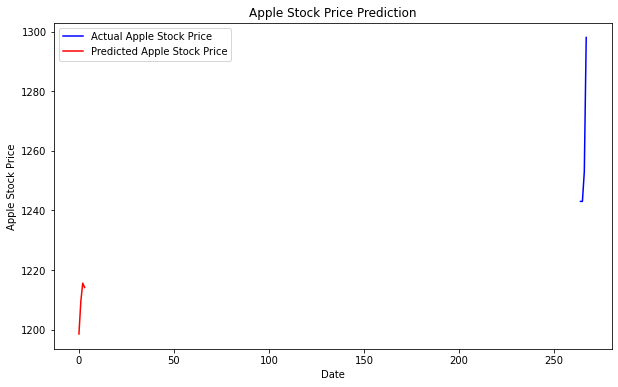

In [ ]:
plt.figure(figsize=(10,6))
df = pd.read_csv(path + file_name)
df_test = df.iloc[df.shape[0]-4:,:]
df_test['target']
plt.plot(df_test['target'], color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

## Теперь обучена сеть lstm которая делает предсказания по данным за последний месяц на следующую неделю

## Прочее

In [ ]:
def scale(X):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))

    X_train = scaler.fit_transform(X[0])
    X_valid = scaler.transform(X[1])

    return X_train, X_valid

In [ ]:
def scale(x,y):
  x_scaler = MinMaxScaler(feature_range=(0, 1))
  y_scaler = MinMaxScaler(feature_range=(0, 1))
  x_scaled = x_scaler.fit_transform(x)
  y_scaled = y_scaler.fit_transform(y)

  return x_scaled, y_scaled, x_scaler, y_scaler

  

In [ ]:
def split(df, num_of_splits, num_of_weeks):
  '''
  Принимает на вход датафрейм, формирует из него num_of_splits выборок типа: предыстория - значение target'a наперед на num_of_weeks
  '''
  

In [ ]:
def split_scale(train, valid, num_of_weeks):
    '''
    Выделяет из train столбики с именами target_in_{num}_weeks как y_train, остальное как X_train
    '''
    targets = ['target_in_'+str(week)+'_weeks' for week in range(1, num_of_weeks+1)]
    X_train = train.drop(targets, axis=1)
    X_valid = valid.drop(targets, axis=1)
    y_train = train[targets]
    y_valid = valid[targets]

    X_train, X_valid = scale([X_train, X_valid])

    data = {'X_train': X_train,
            'X_valid': X_valid,
            'y_train': y_train,
            'y_valid': y_valid}

    return data

In [ ]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

def nn_model_train(data, num_weeks):
    results = []
    X_train, X_valid, y_train, y_valid = data.values()
    inp_size = X_train.shape[1]

    model = Sequential()
    #for layer in range(num_layers):
    #  model.add(Dense(hidden_dim,activation='relu',input_shape=(inp_size,)))
    #  model.add(BatchNormalization())
    #  model.add(Dropout(p))
    #  inp_size=hidden_dim
    #model.add(Dense(num_weeks))
    model.add(Dense(512, activation='relu', input_shape=(inp_size,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_weeks))

    # model_checkpoint_callback = ModelCheckpoint(filepath=path,
    #                                             save_weights_only=True,
    #                                             monitor='val_mae',
    #                                             mode='min',
    #                                             save_best_only=True)

    model_early_stop_callback = EarlyStopping(monitor="val_loss",
                                              patience=200,
                                              verbose=1,
                                              mode="min")
    
    model.compile(optimizer='rmsprop', 
                  loss='mse', 
                  metrics=['mae'])
    
    history = model.fit(X_train, y_train,
                        steps_per_epoch=1,
                        epochs=5000,
                        callbacks=[model_early_stop_callback],
                        validation_data=(X_valid, y_valid),
                        validation_steps=1)
    
    # y_train_pred = model.predict(X_train, steps=1)
    y_pred = model.predict(X_valid, steps=1)

    # score_train = mse(y_train, y_train_pred) ** 0.5
    # score_valid = mse(y_valid, y_pred) ** 0.5
    score_train = None
    score_valid = None
    
    return history, (score_train, score_valid), y_pred

In [ ]:
values = df.values
tscv = TimeSeriesSplit(n_splits=3,test_size=4)
for train,test in tscv.split(values):
  print(values[train],values[test])

In [ ]:
#df.drop('timepoint',inplace=True,axis=1)
values = df.values
tscv = TimeSeriesSplit(n_splits=3,test_size=1)
for train, test in tscv.split(values):
    model = RandomForestRegressor(n_estimators=1000,
#                                   max_depth=3,
                                  random_state=13,
                                  verbose=100)
                                  #n_outputs_=len(test))
    #model = Perceptron(input_dim = len(train), output_dim=len(test),num_layers=3)
    model.fit(np.array(values[train]),np.array(values[test]))
    score_train = model.score(np.array(values[train]),np.array(values[test]))
    print(score_train)
    y_pred = model.predict(list(values[train]))
    score_train = mse(y_pred, values[test]) ** 0.5

In [ ]:
# Time Validation
def time_valid(df_, num_of_weeks=1, valid_step=1):
    cache = {'scores': [],
             'histories': [],
             'y_pred': []}
    # In order to save original df
    df = df_.copy()

    # Shift target values for prediction
    for week in range(1, num_of_weeks+1):
        df['target_in_'+str(week)+'_weeks'] = df['target'].shift(periods=-week)
    
    # Save rows without information about future
    # cache['test_val'] = df[df['target_in_'+str(num_of_weeks)+'_weeks'].isna()]['target']
    # And drop them, as we do not know targets ahead of them


    # тут стоит обрабатывать разные предсказатели по-разному. больше  объектов не удалится
    df = df[df['target_in_'+str(num_of_weeks)+'_weeks'].notna()]
    # return df, cache
    length = df.shape[0]

    for valid in range(valid_step):
        val_end = length - valid
        val_start = val_end - num_of_weeks

        df_train = df.iloc[:val_start].copy()
        df_valid = df.iloc[val_start:val_end].copy()

        data = split_scale(df_train, df_valid, num_of_weeks)

        history, score, y_pred = nn_model_train(data, num_of_weeks)#,num_layers=num_layers,p=p,hidden_dim=hidden_dim)
        cache['scores'].append(score)
        cache['histories'].append(history)
        cache['y_pred'].append(y_pred)
        print(y_pred)
    
    return cache

In [ ]:
#df_ = df.drop(['timepoint'],axis=1)
cache = time_valid(df)#,p=0.2,num_layers=4,hidden_dim=256)

In [ ]:
def plot_history(history):
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training mae')
    plt.plot(epochs, val_acc, 'b', label='Validation mae')
    plt.title('Training and Validation mae')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

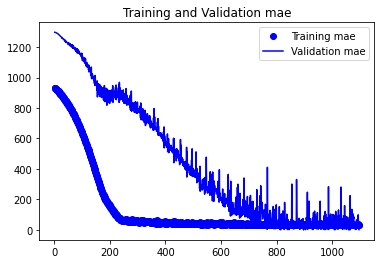

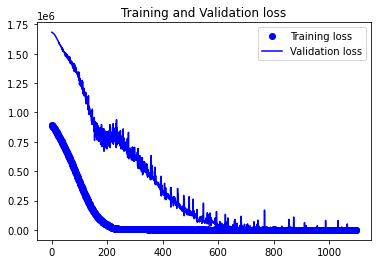

In [ ]:
for history in cache['histories']:
    plot_history(history)

In [ ]:
# score_train = model.score(X_train, y_train)
#     y_pred = model.predict(X_valid)
#     score_valid = mse(y_valid, y_pred) ** 0.5

#     print(model.feature_importances_)

In [ ]:
# eval_set = [(X_train, y_train), (X_valid, y_valid)]

# xgbr = xgb.XGBRegressor(objective='reg:squarederror',
#                         max_depth=2,
#                         colsample_by_tree=0.7,
#                         gamma=1.5,
#                         eta=0.01)

# xgbr.fit(X_train, y_train,
#             eval_metric=['rmse', 'rmse'],
#             eval_set=eval_set,
#             early_stopping_rounds=100,
#             verbose=2)

# score_train = xgbr.score(X_train, y_train)

# y_pred = xgbr.predict(X_valid)